In [265]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import rtree

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 7)

In [266]:
gdf_burbs = gpd.read_file("DATA/NOV21_NSW_LOC_POLYGON_shp/nsw_localities.shp") # Importing 
print("done")

done


<AxesSubplot:>

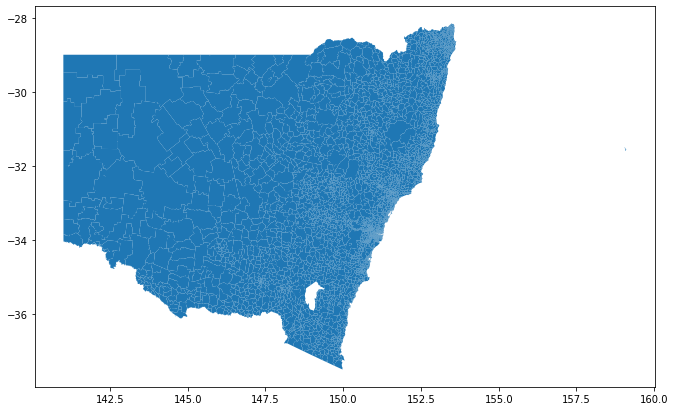

In [267]:
gdf_burbs.plot()

In [268]:
gdf_burbs.head(2)

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,lcp012ec80364d0,loc56c2712d9100,2021-06-24,Aarons Pass,Gazetted Locality,NSW,"POLYGON ((149.79499 -32.82275, 149.79403 -32.8..."
1,lcp4c73aef97a2a,loc826143633965,2021-09-08,Abbotsbury,Gazetted Locality,NSW,"POLYGON ((150.87268 -33.86044, 150.87254 -33.8..."


In [273]:
df = pd.read_csv("data/NSW_Road_Crash_Data_2016-2020.csv")
print("done")

done


In [270]:
gdf_crashData = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [271]:
gdf_join = gdf_crashData.sjoin(gdf_burbs[["LOC_NAME", "geometry"]], how="left", predicate="within")

c:\Users\Louis\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4283

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [276]:
counts_by_year = gdf_join.value_counts(["Year of crash", "LOC_NAME"]).to_frame().reset_index().sort_values(["LOC_NAME", "Year of crash"])
counts_by_year.head(2)

,Year of crash,LOC_NAME,0
9656,2016,Aarons Pass,1
8618,2018,Aarons Pass,2


In [277]:
counts_by_year.columns = ["year", "suburb", "crashes"]
counts_by_year.head(2)

,year,suburb,crashes
9656,2016,Aarons Pass,1
8618,2018,Aarons Pass,2


In [278]:
pivoted = counts_by_year.pivot(index="suburb", columns="year", values="crashes")
pivoted.head(2)

year,2015,2016,2017,2018,2019,2020
suburb,,,,,,
Aarons Pass,NaN,1.0,NaN,2.0,NaN,NaN
Abbotsbury,NaN,14.0,16.0,4.0,9.0,14.0


In [279]:
pivoted_gdf = gpd.GeoDataFrame((pd.merge(pivoted, gdf_burbs[["LOC_NAME", "geometry"]], how="left", left_index=True, right_on="LOC_NAME")), geometry="geometry", crs=4326)
pivoted_gdf.head(2)

,2015,2016,2017,2018,2019,2020,LOC_NAME,geometry
0,NaN,1.0,NaN,2.0,NaN,NaN,Aarons Pass,"POLYGON ((149.79499 -32.82275, 149.79403 -32.8..."
1,NaN,14.0,16.0,4.0,9.0,14.0,Abbotsbury,"POLYGON ((150.87268 -33.86044, 150.87254 -33.8..."


In [280]:
sum_cols = [2015, 2016, 2017, 2018, 2019, 2020]

pivoted_gdf["total_crashes"] = pivoted_gdf[sum_cols].sum(axis=1)

In [281]:
pivoted_gdf = pivoted_gdf.fillna(0)
pivoted_gdf[[2015, 2016, 2017, 2018, 2019, 2020, "total_crashes"]] = pivoted_gdf[[2015, 2016, 2017, 2018, 2019, 2020, "total_crashes"]].astype(int)

In [282]:
pivoted_gdf = pivoted_gdf.sort_values("total_crashes", ascending=False)

In [284]:
pivoted_gdf.head(10)

,2015,2016,2017,2018,2019,2020,LOC_NAME,geometry,total_crashes
180,1,222,216,165,163,146,Bankstown,"POLYGON ((151.03769 -33.90387, 151.03828 -33.9...",913
2406,0,213,192,138,131,120,Liverpool,"POLYGON ((150.91795 -33.90467, 150.91841 -33.9...",794
3777,1,199,173,176,144,93,Sydney,"POLYGON ((151.21567 -33.85619, 151.21568 -33.8...",786
106,1,227,169,112,123,87,Auburn,"POLYGON ((151.02634 -33.83503, 151.02643 -33.8...",719
2639,1,170,150,127,97,105,Merrylands,"POLYGON ((150.98705 -33.82279, 150.98710 -33.8...",650
398,1,125,154,127,104,133,Blacktown,"POLYGON ((150.92631 -33.75072, 150.92777 -33.7...",644
1793,0,166,130,97,112,91,Greenacre,"POLYGON ((151.06855 -33.88096, 151.06865 -33.8...",596
2361,0,166,152,82,99,84,Lidcombe,"POLYGON ((151.04466 -33.84239, 151.04471 -33.8...",583
2566,0,147,134,104,109,72,Mascot,"POLYGON ((151.18825 -33.92030, 151.18866 -33.9...",566
3212,1,151,138,104,96,66,Parramatta,"POLYGON ((151.00510 -33.80452, 151.00522 -33.8...",556


<AxesSubplot:>

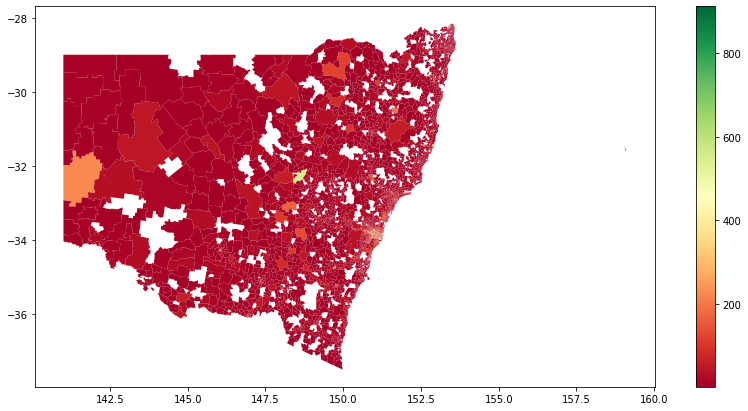

In [285]:
pivoted_gdf.plot(column="total_crashes", cmap="RdYlGn", legend=True)

In [288]:
pivoted_gdf.dtypes

2015                int32
2016                int32
2017                int32
2018                int32
2019                int32
2020                int32
LOC_NAME           object
geometry         geometry
total_crashes       int32
dtype: object

In [294]:
pivoted_gdf.explore(column="total_crashes", name="Total Crashes")

TypeError: '<' not supported between instances of 'str' and 'int'